In [1]:
from torch import Tensor, nn

from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from tqdm.auto import tqdm
from tqdm import tqdm
import numpy as np
import pandas as pd
import gc
import requests
import os
import sys
import json
from sklearn.model_selection import train_test_split

from functools import wraps as _wraps
from typing import List, Tuple, Literal, Optional, Union, Sequence, Any
import atexit as _atexit
import math
import os
import sys
import json
from collections import defaultdict
import time
import gc
import requests
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from tqdm.auto import tqdm
from tqdm import tqdm


from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
    # Falcon VLM (LLaVA-Next style)
    LlavaNextForConditionalGeneration,
    LlavaNextProcessor,
)

from datasets import load_dataset

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

2025-10-17 12:11:36.427204: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 12:11:38.217332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760721099.436926  517110 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760721099.622581  517110 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760721101.774022  517110 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Residual stream embeddings as a proxy for low-d triplet behavioral judgments

In [2]:
llm = AutoModelForCausalLM.from_pretrained(
                "google/gemma-3-27b-it",
                cache_dir="/mnt/dv/wid/projects3/Rogers-muri-human-ai/zstuddiford",
                torch_dtype="auto",
                trust_remote_code=True,
                device_map={"": "cuda:0"},   # <-- force all layers on GPU
            )



`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-27b-it", cache_dir="/mnt/dv/wid/projects3/Rogers-muri-human-ai/zstuddiford", trust_remote_code=True)


In [1]:
def article_to_sentences(article_text):
    return sent_tokenize(article_text)

In [5]:
embed_ref = pd.read_csv("model_triplet_output_gemma-3-27b-it_THINGS_embedding.csv")

In [6]:
embed_ref

,item,id,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,...,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29
0,airbag,0,-0.121638,-0.115255,0.056533,-0.008403,0.136553,0.020736,0.093908,-0.010561,...,0.000085,0.085156,-0.103403,-0.097392,-0.074894,0.143406,0.026868,0.053514,0.002504,0.135532
1,album,1,0.011931,0.068101,0.062446,0.005122,-0.001907,-0.077468,-0.096201,0.070769,...,0.073284,-0.015280,-0.008695,-0.060691,0.063421,0.079019,-0.017326,0.096959,0.066413,-0.030845
2,appetizer,2,0.082968,-0.039242,0.122695,0.047040,-0.135993,-0.140231,-0.056439,0.131733,...,0.111166,-0.135537,0.128708,0.087017,0.127686,-0.091639,-0.109793,0.052131,0.132931,-0.144952
3,applesauce,3,0.092454,-0.044395,0.137838,0.053505,-0.167254,-0.157231,-0.069313,0.139696,...,0.120897,-0.153029,0.151641,0.129688,0.145013,-0.132255,-0.088039,0.011386,0.153218,-0.149624
4,backscratcher,4,-0.004857,0.155154,-0.143333,-0.054272,-0.004501,0.055762,-0.050834,-0.125288,...,-0.058474,0.097709,-0.019686,-0.025476,-0.051457,-0.016363,0.069999,-0.070621,-0.124620,0.013432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,veil,123,0.007029,0.005607,-0.017702,-0.010985,0.009928,-0.061234,-0.012244,0.054958,...,0.046682,-0.044822,0.064074,0.041411,0.036398,0.048793,0.017889,-0.012089,0.028138,0.013530
124,visor,124,-0.069187,-0.023381,-0.070359,-0.053481,0.116526,0.061199,0.084842,-0.013193,...,-0.038636,0.036260,-0.050651,-0.046536,-0.050253,0.124597,0.042514,0.016810,-0.068835,0.073999
125,volleyball,125,0.041743,-0.001210,-0.107810,0.057876,0.110557,0.096796,0.143934,0.087572,...,-0.108638,-0.069324,-0.138552,-0.092597,-0.045739,0.121473,-0.059965,0.079909,-0.033339,-0.013740
126,waffle,126,-0.026252,-0.121747,0.122968,-0.066128,-0.021160,-0.160939,-0.051448,0.197205,...,0.168358,-0.155383,0.143094,0.071714,0.154945,0.055998,0.061067,0.102023,0.140295,-0.072118


In [7]:
words = embed_ref["item"].astype(str).tolist()
target_count = 100


In [8]:
dataset = load_dataset("wikimedia/wikipedia", "20231101.en", split="train", streaming=True)


Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

In [9]:
word_sentences = pd.read_csv("wiki_word_sentences.csv")

In [55]:
import re
from tqdm import tqdm
from collections import defaultdict

target_count = 100
MAX_ARTICLES_PER_WORD = 5000

word_sentences = defaultdict(list)
word_seen_set = defaultdict(set)
skipped = set()

word_regex = {w: re.compile(rf"\b{re.escape(w.lower())}\b") for w in words}

# Process each word independently
for w in words:
    articles_checked = 0
    
    pbar = tqdm(dataset, desc=f"📚 Scanning for '{w}'", unit="article")
    
    for article in pbar:
        articles_checked += 1
        
        # Check if we've hit the limit for this word
        if articles_checked > MAX_ARTICLES_PER_WORD:
            skipped.add(w)
            print(f"⚠️ '{w}' skipped — {len(word_seen_set[w])} unique sentences found after {MAX_ARTICLES_PER_WORD} articles.")
            break
        
        text = article["text"].lower()
        sentences = sent_tokenize(text)
        
        if word_regex[w].search(text):
            for s in sentences:
                if word_regex[w].search(s):
                    if s not in word_seen_set[w]:
                        word_seen_set[w].add(s)
                        word_sentences[w].append(s)
                        if len(word_sentences[w]) >= target_count:
                            print(f"✅ '{w}' complete — {len(word_seen_set[w])} unique sentences found.")
                            break
            
            # Break out if we have enough sentences
            if len(word_sentences[w]) >= target_count:
                break
        
        pbar.set_postfix({"sentences": len(word_sentences[w])})
    
    pbar.close()

lengths = [len(v) for v in word_sentences.values()]
avg_len = (sum(lengths) / len(lengths)) if lengths else 0
print(f"📊 Avg sentences/word: {avg_len:.2f} | "
      f"complete: {sum(l >= target_count for l in lengths)}/{len(words)} | "
      f"skipped: {len(skipped)}")

📚 Scanning for 'airbag': 5000article [00:15, 314.18article/s, sentences=1]


⚠️ 'airbag' skipped — 1 unique sentences found after 5000 articles.


📚 Scanning for 'album': 153article [00:01, 108.60article/s, sentences=36]


✅ 'album' complete — 100 unique sentences found.


📚 Scanning for 'appetizer': 5000article [00:15, 314.75article/s, sentences=3]


⚠️ 'appetizer' skipped — 3 unique sentences found after 5000 articles.


📚 Scanning for 'applesauce': 5000article [00:15, 317.46article/s, sentences=0]


⚠️ 'applesauce' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'backscratcher': 5000article [00:15, 319.89article/s, sentences=0]


⚠️ 'backscratcher' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'badger': 5000article [00:15, 318.79article/s, sentences=12]


⚠️ 'badger' skipped — 12 unique sentences found after 5000 articles.


📚 Scanning for 'bag': 3840article [00:14, 270.34article/s, sentences=89]


✅ 'bag' complete — 100 unique sentences found.


📚 Scanning for 'baklava': 5000article [00:16, 309.52article/s, sentences=1]


⚠️ 'baklava' skipped — 1 unique sentences found after 5000 articles.


📚 Scanning for 'banjo': 1629article [00:07, 215.06article/s, sentences=14]


✅ 'banjo' complete — 100 unique sentences found.


📚 Scanning for 'baseball': 406article [00:02, 169.54article/s, sentences=96]


✅ 'baseball' complete — 100 unique sentences found.


📚 Scanning for 'baseball glove': 5000article [00:16, 307.55article/s, sentences=1]


⚠️ 'baseball glove' skipped — 1 unique sentences found after 5000 articles.


📚 Scanning for 'bassinet': 5000article [00:15, 314.65article/s, sentences=0]


⚠️ 'bassinet' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'bassoon': 1795article [00:08, 221.19article/s, sentences=9]


✅ 'bassoon' complete — 100 unique sentences found.


📚 Scanning for 'bathrobe': 5000article [00:16, 303.16article/s, sentences=1]


⚠️ 'bathrobe' skipped — 1 unique sentences found after 5000 articles.


📚 Scanning for 'bathtub': 5000article [00:15, 323.84article/s, sentences=5]


⚠️ 'bathtub' skipped — 5 unique sentences found after 5000 articles.


📚 Scanning for 'beachball': 5000article [00:16, 305.11article/s, sentences=0]


⚠️ 'beachball' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'beanbag': 5000article [00:16, 312.12article/s, sentences=0]


⚠️ 'beanbag' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'beanie': 5000article [00:15, 322.84article/s, sentences=4]


⚠️ 'beanie' skipped — 4 unique sentences found after 5000 articles.


📚 Scanning for 'bear': 797article [00:03, 205.20article/s, sentences=99]


✅ 'bear' complete — 100 unique sentences found.


📚 Scanning for 'bed': 1706article [00:07, 218.61article/s, sentences=99]


✅ 'bed' complete — 100 unique sentences found.


📚 Scanning for 'beer': 1425article [00:06, 222.21article/s, sentences=84]


✅ 'beer' complete — 100 unique sentences found.


📚 Scanning for 'bench': 5000article [00:15, 315.71article/s, sentences=84]


⚠️ 'bench' skipped — 84 unique sentences found after 5000 articles.


📚 Scanning for 'blower': 5000article [00:16, 310.25article/s, sentences=8]


⚠️ 'blower' skipped — 8 unique sentences found after 5000 articles.


📚 Scanning for 'bok choy': 5000article [00:16, 308.33article/s, sentences=5]


⚠️ 'bok choy' skipped — 5 unique sentences found after 5000 articles.


📚 Scanning for 'bongo': 5000article [00:15, 313.61article/s, sentences=62]


⚠️ 'bongo' skipped — 62 unique sentences found after 5000 articles.


📚 Scanning for 'bow': 764article [00:03, 204.68article/s, sentences=51]


✅ 'bow' complete — 100 unique sentences found.


📚 Scanning for 'bracelet': 5000article [00:16, 311.39article/s, sentences=13]


⚠️ 'bracelet' skipped — 13 unique sentences found after 5000 articles.


📚 Scanning for 'bread': 1425article [00:06, 218.56article/s, sentences=97]


✅ 'bread' complete — 100 unique sentences found.


📚 Scanning for 'butterfly': 5000article [00:16, 309.77article/s, sentences=83]


⚠️ 'butterfly' skipped — 83 unique sentences found after 5000 articles.


📚 Scanning for 'button': 2734article [00:12, 217.95article/s, sentences=99]


✅ 'button' complete — 100 unique sentences found.


📚 Scanning for 'cannonball': 5000article [00:15, 313.85article/s, sentences=7]


⚠️ 'cannonball' skipped — 7 unique sentences found after 5000 articles.


📚 Scanning for 'canvas': 5000article [00:16, 303.56article/s, sentences=45]


⚠️ 'canvas' skipped — 45 unique sentences found after 5000 articles.


📚 Scanning for 'carriage': 5000article [00:16, 309.77article/s, sentences=90]


⚠️ 'carriage' skipped — 90 unique sentences found after 5000 articles.


📚 Scanning for 'chainsaw': 5000article [00:16, 309.15article/s, sentences=3]


⚠️ 'chainsaw' skipped — 3 unique sentences found after 5000 articles.


📚 Scanning for 'chaps': 5000article [00:15, 315.59article/s, sentences=0]


⚠️ 'chaps' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'chipmunk': 5000article [00:15, 321.12article/s, sentences=4]


⚠️ 'chipmunk' skipped — 4 unique sentences found after 5000 articles.


📚 Scanning for 'coaster': 5000article [00:16, 302.19article/s, sentences=20]


⚠️ 'coaster' skipped — 20 unique sentences found after 5000 articles.


📚 Scanning for 'computer screen': 5000article [00:15, 314.22article/s, sentences=7]


⚠️ 'computer screen' skipped — 7 unique sentences found after 5000 articles.


📚 Scanning for 'cooker': 5000article [00:15, 318.41article/s, sentences=4]


⚠️ 'cooker' skipped — 4 unique sentences found after 5000 articles.


📚 Scanning for 'cot': 5000article [00:15, 315.39article/s, sentences=8]


⚠️ 'cot' skipped — 8 unique sentences found after 5000 articles.


📚 Scanning for 'couch': 5000article [00:16, 310.12article/s, sentences=21]


⚠️ 'couch' skipped — 21 unique sentences found after 5000 articles.


📚 Scanning for 'cow': 5000article [00:15, 319.07article/s, sentences=87]


⚠️ 'cow' skipped — 87 unique sentences found after 5000 articles.


📚 Scanning for 'crepe': 5000article [00:16, 308.18article/s, sentences=2]


⚠️ 'crepe' skipped — 2 unique sentences found after 5000 articles.


📚 Scanning for 'crib': 5000article [00:15, 319.92article/s, sentences=17]


⚠️ 'crib' skipped — 17 unique sentences found after 5000 articles.


📚 Scanning for 'crow': 5000article [00:16, 310.64article/s, sentences=78]


⚠️ 'crow' skipped — 78 unique sentences found after 5000 articles.


📚 Scanning for 'cupcake': 5000article [00:15, 315.25article/s, sentences=3]


⚠️ 'cupcake' skipped — 3 unique sentences found after 5000 articles.


📚 Scanning for 'cymbal': 5000article [00:16, 302.72article/s, sentences=29]


⚠️ 'cymbal' skipped — 29 unique sentences found after 5000 articles.


📚 Scanning for 'dessert': 5000article [00:16, 309.27article/s, sentences=33]


⚠️ 'dessert' skipped — 33 unique sentences found after 5000 articles.


📚 Scanning for 'doily': 5000article [00:16, 302.45article/s, sentences=0]


⚠️ 'doily' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'doorknob': 5000article [00:15, 317.79article/s, sentences=0]


⚠️ 'doorknob' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'doorknocker': 5000article [00:15, 318.64article/s, sentences=0]


⚠️ 'doorknocker' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'dough': 5000article [00:15, 318.61article/s, sentences=26]


⚠️ 'dough' skipped — 26 unique sentences found after 5000 articles.


📚 Scanning for 'enchilada': 5000article [00:16, 305.11article/s, sentences=0]


⚠️ 'enchilada' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'exhaust pipe': 5000article [00:15, 318.38article/s, sentences=1]


⚠️ 'exhaust pipe' skipped — 1 unique sentences found after 5000 articles.


📚 Scanning for 'extinguisher': 5000article [00:16, 305.50article/s, sentences=5]


⚠️ 'extinguisher' skipped — 5 unique sentences found after 5000 articles.


📚 Scanning for 'fire alarm': 5000article [00:15, 313.70article/s, sentences=1]


⚠️ 'fire alarm' skipped — 1 unique sentences found after 5000 articles.


📚 Scanning for 'fishbowl': 5000article [00:15, 313.41article/s, sentences=3]


⚠️ 'fishbowl' skipped — 3 unique sentences found after 5000 articles.


📚 Scanning for 'flower': 1472article [00:06, 214.92article/s, sentences=99]


✅ 'flower' complete — 100 unique sentences found.


📚 Scanning for 'fly': 763article [00:03, 204.50article/s, sentences=99]


✅ 'fly' complete — 100 unique sentences found.


📚 Scanning for 'giraffe': 5000article [00:16, 301.36article/s, sentences=4]


⚠️ 'giraffe' skipped — 4 unique sentences found after 5000 articles.


📚 Scanning for 'gourd': 5000article [00:16, 300.75article/s, sentences=13]


⚠️ 'gourd' skipped — 13 unique sentences found after 5000 articles.


📚 Scanning for 'grapefruit': 5000article [00:16, 306.33article/s, sentences=9]


⚠️ 'grapefruit' skipped — 9 unique sentences found after 5000 articles.


📚 Scanning for 'grasshopper': 5000article [00:16, 304.22article/s, sentences=3]


⚠️ 'grasshopper' skipped — 3 unique sentences found after 5000 articles.


📚 Scanning for 'gravy': 5000article [00:15, 313.18article/s, sentences=8]


⚠️ 'gravy' skipped — 8 unique sentences found after 5000 articles.


📚 Scanning for 'guitar': 1417article [00:06, 217.79article/s, sentences=99]


✅ 'guitar' complete — 100 unique sentences found.


📚 Scanning for 'hat': 2272article [00:10, 222.64article/s, sentences=98]


✅ 'hat' complete — 100 unique sentences found.


📚 Scanning for 'hatchet': 5000article [00:16, 311.66article/s, sentences=14]


⚠️ 'hatchet' skipped — 14 unique sentences found after 5000 articles.


📚 Scanning for 'honeypot': 5000article [00:15, 314.31article/s, sentences=2]


⚠️ 'honeypot' skipped — 2 unique sentences found after 5000 articles.


📚 Scanning for 'hot-air balloon': 5000article [00:15, 314.74article/s, sentences=2]


⚠️ 'hot-air balloon' skipped — 2 unique sentences found after 5000 articles.


📚 Scanning for 'hula hoop': 5000article [00:15, 313.89article/s, sentences=0]


⚠️ 'hula hoop' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'hummus': 5000article [00:16, 296.13article/s, sentences=1]


⚠️ 'hummus' skipped — 1 unique sentences found after 5000 articles.


📚 Scanning for 'humvee': 5000article [00:16, 307.03article/s, sentences=5]


⚠️ 'humvee' skipped — 5 unique sentences found after 5000 articles.


📚 Scanning for 'hyena': 5000article [00:16, 306.13article/s, sentences=18]


⚠️ 'hyena' skipped — 18 unique sentences found after 5000 articles.


📚 Scanning for 'iguana': 5000article [00:16, 307.66article/s, sentences=6]


⚠️ 'iguana' skipped — 6 unique sentences found after 5000 articles.


📚 Scanning for 'jeans': 5000article [00:16, 307.21article/s, sentences=18]


⚠️ 'jeans' skipped — 18 unique sentences found after 5000 articles.


📚 Scanning for 'kilt': 5000article [00:15, 317.17article/s, sentences=4]


⚠️ 'kilt' skipped — 4 unique sentences found after 5000 articles.


📚 Scanning for 'kimono': 5000article [00:16, 305.02article/s, sentences=2]


⚠️ 'kimono' skipped — 2 unique sentences found after 5000 articles.


📚 Scanning for 'kneepad': 5000article [00:16, 307.39article/s, sentences=0]


⚠️ 'kneepad' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'knitting needle': 5000article [00:16, 305.55article/s, sentences=0]


⚠️ 'knitting needle' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'knob': 5000article [00:16, 311.25article/s, sentences=14]


⚠️ 'knob' skipped — 14 unique sentences found after 5000 articles.


📚 Scanning for 'lawnmower': 5000article [00:16, 305.45article/s, sentences=4]


⚠️ 'lawnmower' skipped — 4 unique sentences found after 5000 articles.


📚 Scanning for 'leek': 5000article [00:15, 312.69article/s, sentences=15]


⚠️ 'leek' skipped — 15 unique sentences found after 5000 articles.


📚 Scanning for 'lion': 1667article [00:07, 221.73article/s, sentences=99]


✅ 'lion' complete — 100 unique sentences found.


📚 Scanning for 'mango': 5000article [00:15, 319.06article/s, sentences=34]


⚠️ 'mango' skipped — 34 unique sentences found after 5000 articles.


📚 Scanning for 'margarita': 5000article [00:16, 312.35article/s, sentences=27]


⚠️ 'margarita' skipped — 27 unique sentences found after 5000 articles.


📚 Scanning for 'mashed potato': 5000article [00:16, 311.54article/s, sentences=2]


⚠️ 'mashed potato' skipped — 2 unique sentences found after 5000 articles.


📚 Scanning for 'milkshake': 5000article [00:15, 313.90article/s, sentences=36]


⚠️ 'milkshake' skipped — 36 unique sentences found after 5000 articles.


📚 Scanning for 'missile': 644article [00:03, 202.03article/s, sentences=27]


✅ 'missile' complete — 100 unique sentences found.


📚 Scanning for 'mosquito': 5000article [00:16, 302.68article/s, sentences=17]


⚠️ 'mosquito' skipped — 17 unique sentences found after 5000 articles.


📚 Scanning for 'mouse': 2551article [00:11, 216.73article/s, sentences=99]


✅ 'mouse' complete — 100 unique sentences found.


📚 Scanning for 'oatmeal': 5000article [00:16, 310.89article/s, sentences=5]


⚠️ 'oatmeal' skipped — 5 unique sentences found after 5000 articles.


📚 Scanning for 'odometer': 5000article [00:16, 302.08article/s, sentences=3]


⚠️ 'odometer' skipped — 3 unique sentences found after 5000 articles.


📚 Scanning for 'owl': 2878article [00:12, 227.05article/s, sentences=51]


✅ 'owl' complete — 100 unique sentences found.


📚 Scanning for 'parfait': 5000article [00:15, 315.80article/s, sentences=0]


⚠️ 'parfait' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'parrot': 5000article [00:16, 307.73article/s, sentences=24]


⚠️ 'parrot' skipped — 24 unique sentences found after 5000 articles.


📚 Scanning for 'pinball': 5000article [00:15, 317.97article/s, sentences=9]


⚠️ 'pinball' skipped — 9 unique sentences found after 5000 articles.


📚 Scanning for 'pocket watch': 5000article [00:15, 316.40article/s, sentences=1]


⚠️ 'pocket watch' skipped — 1 unique sentences found after 5000 articles.


📚 Scanning for 'puffin': 5000article [00:16, 306.32article/s, sentences=7]


⚠️ 'puffin' skipped — 7 unique sentences found after 5000 articles.


📚 Scanning for 'pumpkin': 5000article [00:16, 310.19article/s, sentences=30]


⚠️ 'pumpkin' skipped — 30 unique sentences found after 5000 articles.


📚 Scanning for 'quesadilla': 5000article [00:15, 313.19article/s, sentences=0]


⚠️ 'quesadilla' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'quiche': 5000article [00:16, 308.30article/s, sentences=2]


⚠️ 'quiche' skipped — 2 unique sentences found after 5000 articles.


📚 Scanning for 'ravioli': 5000article [00:15, 312.65article/s, sentences=4]


⚠️ 'ravioli' skipped — 4 unique sentences found after 5000 articles.


📚 Scanning for 'sea urchin': 5000article [00:16, 312.08article/s, sentences=1]


⚠️ 'sea urchin' skipped — 1 unique sentences found after 5000 articles.


📚 Scanning for 'shuffleboard': 5000article [00:16, 310.01article/s, sentences=4]


⚠️ 'shuffleboard' skipped — 4 unique sentences found after 5000 articles.


📚 Scanning for 'skeleton': 2339article [00:10, 214.77article/s, sentences=99]


✅ 'skeleton' complete — 100 unique sentences found.


📚 Scanning for 'snail': 5000article [00:15, 314.16article/s, sentences=16]


⚠️ 'snail' skipped — 16 unique sentences found after 5000 articles.


📚 Scanning for 'snake': 2389article [00:11, 216.21article/s, sentences=93]


✅ 'snake' complete — 100 unique sentences found.


📚 Scanning for 'souffle': 5000article [00:15, 315.96article/s, sentences=1]


⚠️ 'souffle' skipped — 1 unique sentences found after 5000 articles.


📚 Scanning for 'stew': 5000article [00:16, 307.21article/s, sentences=20]


⚠️ 'stew' skipped — 20 unique sentences found after 5000 articles.


📚 Scanning for 'swab': 5000article [00:15, 318.56article/s, sentences=4]


⚠️ 'swab' skipped — 4 unique sentences found after 5000 articles.


📚 Scanning for 'taillight': 5000article [00:15, 315.40article/s, sentences=1]


⚠️ 'taillight' skipped — 1 unique sentences found after 5000 articles.


📚 Scanning for 'tank': 846article [00:04, 208.53article/s, sentences=66]


✅ 'tank' complete — 100 unique sentences found.


📚 Scanning for 'tarantula': 5000article [00:15, 318.51article/s, sentences=0]


⚠️ 'tarantula' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'taxi': 4498article [00:15, 296.94article/s, sentences=99]


✅ 'taxi' complete — 100 unique sentences found.


📚 Scanning for 'tennis ball': 5000article [00:15, 315.27article/s, sentences=2]


⚠️ 'tennis ball' skipped — 2 unique sentences found after 5000 articles.


📚 Scanning for 'thermos': 5000article [00:16, 308.51article/s, sentences=5]


⚠️ 'thermos' skipped — 5 unique sentences found after 5000 articles.


📚 Scanning for 'toilet paper': 5000article [00:16, 306.40article/s, sentences=3]


⚠️ 'toilet paper' skipped — 3 unique sentences found after 5000 articles.


📚 Scanning for 'tortellini': 5000article [00:15, 316.70article/s, sentences=0]


⚠️ 'tortellini' skipped — 0 unique sentences found after 5000 articles.


📚 Scanning for 'treadmill': 5000article [00:16, 309.23article/s, sentences=4]


⚠️ 'treadmill' skipped — 4 unique sentences found after 5000 articles.


📚 Scanning for 'trowel': 5000article [00:16, 301.46article/s, sentences=5]


⚠️ 'trowel' skipped — 5 unique sentences found after 5000 articles.


📚 Scanning for 'tuxedo': 5000article [00:16, 309.19article/s, sentences=6]


⚠️ 'tuxedo' skipped — 6 unique sentences found after 5000 articles.


📚 Scanning for 'uniform': 816article [00:03, 206.84article/s, sentences=91]


✅ 'uniform' complete — 100 unique sentences found.


📚 Scanning for 'vase': 5000article [00:15, 316.21article/s, sentences=84]


⚠️ 'vase' skipped — 84 unique sentences found after 5000 articles.


📚 Scanning for 'veil': 5000article [00:15, 315.21article/s, sentences=34]


⚠️ 'veil' skipped — 34 unique sentences found after 5000 articles.


📚 Scanning for 'visor': 5000article [00:15, 319.32article/s, sentences=7]


⚠️ 'visor' skipped — 7 unique sentences found after 5000 articles.


📚 Scanning for 'volleyball': 5000article [00:16, 310.08article/s, sentences=93]


⚠️ 'volleyball' skipped — 93 unique sentences found after 5000 articles.


📚 Scanning for 'waffle': 5000article [00:16, 309.57article/s, sentences=8]


⚠️ 'waffle' skipped — 8 unique sentences found after 5000 articles.


📚 Scanning for 'wrap': 5000article [00:15, 320.44article/s, sentences=19]

⚠️ 'wrap' skipped — 19 unique sentences found after 5000 articles.
📊 Avg sentences/word: 29.98 | complete: 24/128 | skipped: 104


In [11]:
import numpy as np

avg_len = np.mean([len(v) for v in word_sentences.values()])
print(f"Average sentences per word: {avg_len:.2f}")


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
import pandas as pd


max_len = max(len(s) for s in word_sentences.values())
for w in word_sentences:
    word_sentences[w] += [""] * (max_len - len(word_sentences[w]))

df = pd.DataFrame(word_sentences)

df.to_csv("wiki_word_sentences.csv", index=False)

print(f"✅ Saved to wiki_word_sentences.csv with {len(df)} rows and {len(df.columns)} columns.")


✅ Saved to wiki_word_sentences.csv with 100 rows and 128 columns.


In [11]:
device="cuda"

In [10]:
word_sentences

,airbag,album,appetizer,applesauce,backscratcher,badger,bag,baklava,banjo,baseball,...,treadmill,trowel,tuxedo,uniform,vase,veil,visor,volleyball,waffle,wrap
0,"passengers were provided with helmets, airbag ...",temporary like achilles is a track on the 1966...,ame: cilantro); entree (refers to ame appetize...,NaN,NaN,traditional ainu cuisine consists of the meat ...,unique words in alabama english include: redwo...,arab cuisine is also known for its sweets and ...,"1949)\n2007 – tommy makem, irish singer-songwr...",some notable examples of alabama literature in...,...,pesticides select for pesticide resistance in ...,"he told matthew arnold, ""everybody likes flatt...","again according to legend, the first americans...","despite separation, the various anarchist scho...",in the later vase paintings presenting the dea...,"in this sense, the literal meanings of 'alchem...",the traditional visor helmet was replaced with...,after 18 years the club returned to the top le...,(japan)\n founding of asunción (paraguay)\n in...,objects wrap around screen edges – for instanc...
1,NaN,"achilles, agony and ecstasy in eight parts is ...",native olympia oysters are served on the half ...,NaN,NaN,more abundant and in varied situations of cons...,"in her only other appearance, she hastily thro...",NaN,"births\n\npre-1600\n 317 – constantius ii, rom...","women\n aberdeen gsfp rfc, an amateur rugby un...",...,treadmills\nbodyweight-supported treadmill tra...,further classified as type a and type b based ...,thereafter the jacket became known as a tuxedo...,the 37 seconds result from the initial differe...,"in book xxiii, the sad spirit of dead patroclu...","tavë kosi (""soured milk casserole"") is the nat...",in ame it can also refer to the visor of a cap...,"the afghan sports federation promotes cricket,...","to further reduce weight, a lightweight magazi...","""ink text"" captured the user's free-hand writi..."
2,NaN,achilles come down is a song on the 2017 gang ...,a typical accompaniment or appetizer of all th...,NaN,NaN,"eventually, during the height of the cold war,...",about seven minutes after stepping onto the mo...,NaN,"births\n\npre-1600\n1355 – philippa, 5th count...",the amsterdam pirates baseball team competes i...,...,"at this time, the area contained large factori...",dibbers come in a variety of designs including...,"the tuxedo was always black until the 1930s, w...","he carries a pistol and a lucky rabbit's foot,...",in the odyssey book xxiv we read dead king aga...,clare waight keller designed meghan markle's w...,a moveable visor (face guard) protected the face.,the albanian athletes have won a total of 43 (...,1987)\n\nholidays and observances\nchristian f...,australian english nag\n chrimbo: abbreviation...
3,NaN,harry james released a version of the blues se...,NaN,NaN,NaN,current examples include the strategic nuclear...,he then folded the bag and tucked it into a po...,NaN,samuel adler classifies the harp as a plucked ...,the odd commercial worked as did the others th...,...,he knocks barry out and ties him to the batmob...,trowel dibber\nthis dibber combines the featur...,he did so because a black tuxedo looked greeni...,"because of the low biodiversity, nutrient use ...",this contrast appears to be shown on the two s...,"to represent antigua and barbuda, agave karatt...","the impact of thousands of arrows, combined wi...",azerbaijan women's volleyball super league is ...,brussels is known for its cuisine and gastrono...,australian english glad wrap/cling wrap\n comm...
4,NaN,(anthology) a 1980 anthology of science fictio...,NaN,NaN,NaN,these animals looked very different from today...,armstrong reminded aldrin of a bag of memorial...,NaN,most ferociously brilliant guitar album (snake...,1973 – the american league of major league b...,...,NaN,"one end is for dibbing, and the other end is s...",marlene dietrich in a tuxedo was considered ve...,"this sour, heavy crude oil blend is designed t...","also from this time fram

In [12]:

def clear_hooks(m):
    if hasattr(m, "_forward_hooks"):
        m._forward_hooks.clear()
    if hasattr(m, "_forward_pre_hooks"):
        m._forward_pre_hooks.clear()
    if hasattr(m, "_backward_hooks"):
        m._backward_hooks.clear()

llm.apply(clear_hooks)
llm.gradient_checkpointing_disable()
llm.model.language_model.gradient_checkpointing = False
llm.config.gradient_checkpointing = False

@torch.no_grad()
def get_resid(sentence, word):
    inputs = tokenizer(sentence, return_tensors="pt").to("cuda")
    resid_out = {}

    def hook_fn(module, _, output):
        hidden = output[0] if isinstance(output, tuple) else output
        resid_out["resid"] = hidden.detach().cpu()

    target_layer = llm.model.language_model.layers[1]
    h = target_layer.mlp.register_forward_hook(hook_fn)
    _ = llm(**inputs)
    h.remove()

    if "resid" not in resid_out:
        return None

    resid = resid_out["resid"][0]
    ids = inputs["input_ids"][0].cpu().tolist()
    tokens = [tokenizer.decode([i]).strip() for i in ids]

    # Match on lowercase substring presence instead of exact token id
    word_l = word.lower()
    matches = [i for i, t in enumerate(tokens) if word_l in t.lower()]

    if not matches:
        return None

    idx = matches[0]
    return resid[idx].to(torch.float32).numpy()


In [13]:
s="passengers were provided with helmets, airbag vests, and in-helmet, bluetooth cell phones."
w="airbag"

res = get_resid(s, w)

print(res)

[ 0.45507812 -0.30664062  0.20507812 ... -0.21582031  0.05151367
  0.24121094]


In [19]:
import os
from tqdm import tqdm
import numpy as np
import torch, gc

os.makedirs("embed_wiki", exist_ok=True)

def cleanup_tensors():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                del obj
        except:
            pass
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

for word in tqdm(word_sentences.columns, desc="Extracting and saving residual embeddings"):
    sents = word_sentences[word].dropna().tolist()
    vecs = []
    print(word)

    for s in sents:
        v = get_resid(s, word)
        if v is not None:
            vecs.append(v)

    if len(vecs) > 0:
        mean_vec = np.mean(vecs, axis=0)
        np.savetxt(f"embed_wiki/{word}.txt", mean_vec)
    else:
        np.savetxt(f"embed_wiki/{word}.txt", np.array([]))

    cleanup_tensors()


Extracting and saving residual embeddings:   0%|          | 0/128 [00:00<?, ?it/s]

airbag


Extracting and saving residual embeddings:   1%|          | 1/128 [00:00<01:33,  1.37it/s]

album


Extracting and saving residual embeddings:   2%|▏         | 2/128 [00:09<11:11,  5.33s/it]

appetizer


Extracting and saving residual embeddings:   2%|▏         | 3/128 [00:10<06:49,  3.28s/it]

applesauce


Extracting and saving residual embeddings:   3%|▎         | 4/128 [00:10<04:35,  2.22s/it]

backscratcher


Extracting and saving residual embeddings:   4%|▍         | 5/128 [00:11<03:21,  1.64s/it]

badger


Extracting and saving residual embeddings:   5%|▍         | 6/128 [00:13<03:24,  1.68s/it]

bag


Extracting and saving residual embeddings:   5%|▌         | 7/128 [00:20<07:27,  3.70s/it]

baklava


Extracting and saving residual embeddings:   6%|▋         | 8/128 [00:21<05:28,  2.74s/it]

banjo


Extracting and saving residual embeddings:   7%|▋         | 9/128 [00:31<09:35,  4.84s/it]

baseball


Extracting and saving residual embeddings:   8%|▊         | 10/128 [01:00<24:13, 12.32s/it]

baseball glove


Extracting and saving residual embeddings:   9%|▊         | 11/128 [01:00<17:04,  8.76s/it]

bassinet


Extracting and saving residual embeddings:   9%|▉         | 12/128 [01:01<12:08,  6.28s/it]

bassoon


Extracting and saving residual embeddings:  10%|█         | 13/128 [01:10<13:22,  6.98s/it]

bathrobe


Extracting and saving residual embeddings:  11%|█         | 14/128 [01:10<09:40,  5.09s/it]

bathtub


Extracting and saving residual embeddings:  12%|█▏        | 15/128 [01:11<07:16,  3.86s/it]

beachball


Extracting and saving residual embeddings:  12%|█▎        | 16/128 [01:12<05:22,  2.88s/it]

beanbag


Extracting and saving residual embeddings:  13%|█▎        | 17/128 [01:12<04:03,  2.20s/it]

beanie


Extracting and saving residual embeddings:  14%|█▍        | 18/128 [01:15<03:56,  2.15s/it]

bear


Extracting and saving residual embeddings:  15%|█▍        | 19/128 [01:23<07:11,  3.96s/it]

bed


Extracting and saving residual embeddings:  16%|█▌        | 20/128 [01:30<09:08,  5.08s/it]

beer


Extracting and saving residual embeddings:  16%|█▋        | 21/128 [01:46<14:51,  8.33s/it]

bench


Extracting and saving residual embeddings:  17%|█▋        | 22/128 [01:54<14:12,  8.05s/it]

blower


Extracting and saving residual embeddings:  18%|█▊        | 23/128 [01:55<10:29,  6.00s/it]

bok choy


Extracting and saving residual embeddings:  19%|█▉        | 24/128 [01:56<07:47,  4.50s/it]

bongo


Extracting and saving residual embeddings:  20%|█▉        | 25/128 [02:01<07:58,  4.65s/it]

bow


Extracting and saving residual embeddings:  20%|██        | 26/128 [02:09<09:29,  5.58s/it]

bracelet


Extracting and saving residual embeddings:  21%|██        | 27/128 [02:10<07:22,  4.39s/it]

bread


Extracting and saving residual embeddings:  22%|██▏       | 28/128 [02:19<09:19,  5.59s/it]

butterfly


Extracting and saving residual embeddings:  23%|██▎       | 29/128 [02:25<09:48,  5.94s/it]

button


Extracting and saving residual embeddings:  23%|██▎       | 30/128 [02:33<10:37,  6.50s/it]

cannonball


Extracting and saving residual embeddings:  24%|██▍       | 31/128 [02:34<07:54,  4.90s/it]

canvas


Extracting and saving residual embeddings:  25%|██▌       | 32/128 [02:39<07:40,  4.80s/it]

carriage


Extracting and saving residual embeddings:  26%|██▌       | 33/128 [02:46<08:48,  5.57s/it]

chainsaw


Extracting and saving residual embeddings:  27%|██▋       | 34/128 [02:47<06:30,  4.15s/it]

chaps


Extracting and saving residual embeddings:  27%|██▋       | 35/128 [02:48<04:47,  3.09s/it]

chipmunk


Extracting and saving residual embeddings:  28%|██▊       | 36/128 [02:49<03:44,  2.44s/it]

coaster


Extracting and saving residual embeddings:  29%|██▉       | 37/128 [02:52<04:04,  2.69s/it]

computer screen


Extracting and saving residual embeddings:  30%|██▉       | 38/128 [02:53<03:19,  2.22s/it]

cooker


Extracting and saving residual embeddings:  30%|███       | 39/128 [02:54<02:46,  1.87s/it]

cot


Extracting and saving residual embeddings:  31%|███▏      | 40/128 [02:55<02:26,  1.66s/it]

couch


Extracting and saving residual embeddings:  32%|███▏      | 41/128 [02:58<02:40,  1.84s/it]

cow


Extracting and saving residual embeddings:  33%|███▎      | 42/128 [03:05<04:57,  3.45s/it]

crepe


Extracting and saving residual embeddings:  34%|███▎      | 43/128 [03:06<03:46,  2.66s/it]

crib


Extracting and saving residual embeddings:  34%|███▍      | 44/128 [03:07<03:23,  2.42s/it]

crow


Extracting and saving residual embeddings:  35%|███▌      | 45/128 [03:17<06:09,  4.46s/it]

cupcake


Extracting and saving residual embeddings:  36%|███▌      | 46/128 [03:18<04:36,  3.37s/it]

cymbal


Extracting and saving residual embeddings:  37%|███▋      | 47/128 [03:20<04:22,  3.24s/it]

dessert


Extracting and saving residual embeddings:  38%|███▊      | 48/128 [03:24<04:24,  3.30s/it]

doily


Extracting and saving residual embeddings:  38%|███▊      | 49/128 [03:25<03:17,  2.51s/it]

doorknob


Extracting and saving residual embeddings:  39%|███▉      | 50/128 [03:25<02:31,  1.94s/it]

doorknocker


Extracting and saving residual embeddings:  40%|███▉      | 51/128 [03:26<01:58,  1.54s/it]

dough


Extracting and saving residual embeddings:  41%|████      | 52/128 [03:28<02:19,  1.84s/it]

enchilada


Extracting and saving residual embeddings:  41%|████▏     | 53/128 [03:29<01:50,  1.47s/it]

exhaust pipe


Extracting and saving residual embeddings:  42%|████▏     | 54/128 [03:30<01:31,  1.24s/it]

extinguisher


Extracting and saving residual embeddings:  43%|████▎     | 55/128 [03:31<01:24,  1.16s/it]

fire alarm


Extracting and saving residual embeddings:  44%|████▍     | 56/128 [03:31<01:14,  1.03s/it]

fishbowl


Extracting and saving residual embeddings:  45%|████▍     | 57/128 [03:32<01:09,  1.02it/s]

flower


Extracting and saving residual embeddings:  45%|████▌     | 58/128 [03:41<03:58,  3.41s/it]

fly


Extracting and saving residual embeddings:  46%|████▌     | 59/128 [03:49<05:29,  4.77s/it]

giraffe


Extracting and saving residual embeddings:  47%|████▋     | 60/128 [03:50<04:06,  3.62s/it]

gourd


Extracting and saving residual embeddings:  48%|████▊     | 61/128 [03:52<03:21,  3.00s/it]

grapefruit


Extracting and saving residual embeddings:  48%|████▊     | 62/128 [03:53<02:45,  2.51s/it]

grasshopper


Extracting and saving residual embeddings:  49%|████▉     | 63/128 [03:54<02:11,  2.03s/it]

gravy


Extracting and saving residual embeddings:  50%|█████     | 64/128 [03:55<01:54,  1.79s/it]

guitar


Extracting and saving residual embeddings:  51%|█████     | 65/128 [04:08<05:17,  5.04s/it]

hat


Extracting and saving residual embeddings:  52%|█████▏    | 66/128 [04:19<07:14,  7.01s/it]

hatchet


Extracting and saving residual embeddings:  52%|█████▏    | 67/128 [04:22<05:37,  5.54s/it]

honeypot


Extracting and saving residual embeddings:  53%|█████▎    | 68/128 [04:22<04:06,  4.11s/it]

hot-air balloon


Extracting and saving residual embeddings:  54%|█████▍    | 69/128 [04:23<03:03,  3.11s/it]

hula hoop


Extracting and saving residual embeddings:  55%|█████▍    | 70/128 [04:24<02:17,  2.37s/it]

hummus


Extracting and saving residual embeddings:  55%|█████▌    | 71/128 [04:24<01:46,  1.88s/it]

humvee


Extracting and saving residual embeddings:  56%|█████▋    | 72/128 [04:25<01:29,  1.60s/it]

hyena


Extracting and saving residual embeddings:  57%|█████▋    | 73/128 [04:28<01:45,  1.91s/it]

iguana


Extracting and saving residual embeddings:  58%|█████▊    | 74/128 [04:29<01:29,  1.65s/it]

jeans


Extracting and saving residual embeddings:  59%|█████▊    | 75/128 [04:31<01:31,  1.72s/it]

kilt


Extracting and saving residual embeddings:  59%|█████▉    | 76/128 [04:32<01:17,  1.49s/it]

kimono


Extracting and saving residual embeddings:  60%|██████    | 77/128 [04:33<01:05,  1.28s/it]

kneepad


Extracting and saving residual embeddings:  61%|██████    | 78/128 [04:33<00:54,  1.09s/it]

knitting needle


Extracting and saving residual embeddings:  62%|██████▏   | 79/128 [04:34<00:46,  1.06it/s]

knob


Extracting and saving residual embeddings:  62%|██████▎   | 80/128 [04:36<00:56,  1.18s/it]

lawnmower


Extracting and saving residual embeddings:  63%|██████▎   | 81/128 [04:37<00:51,  1.11s/it]

leek


Extracting and saving residual embeddings:  64%|██████▍   | 82/128 [04:38<00:59,  1.29s/it]

lion


Extracting and saving residual embeddings:  65%|██████▍   | 83/128 [04:47<02:41,  3.60s/it]

mango


Extracting and saving residual embeddings:  66%|██████▌   | 84/128 [04:51<02:33,  3.48s/it]

margarita


Extracting and saving residual embeddings:  66%|██████▋   | 85/128 [04:53<02:17,  3.20s/it]

mashed potato


Extracting and saving residual embeddings:  67%|██████▋   | 86/128 [04:54<01:43,  2.47s/it]

milkshake


Extracting and saving residual embeddings:  68%|██████▊   | 87/128 [04:57<01:53,  2.77s/it]

missile


Extracting and saving residual embeddings:  69%|██████▉   | 88/128 [05:05<02:55,  4.39s/it]

mosquito


Extracting and saving residual embeddings:  70%|██████▉   | 89/128 [05:08<02:24,  3.69s/it]

mouse


Extracting and saving residual embeddings:  70%|███████   | 90/128 [05:17<03:25,  5.41s/it]

oatmeal


Extracting and saving residual embeddings:  71%|███████   | 91/128 [05:18<02:31,  4.09s/it]

odometer


Extracting and saving residual embeddings:  72%|███████▏  | 92/128 [05:19<01:52,  3.12s/it]

owl


Extracting and saving residual embeddings:  73%|███████▎  | 93/128 [05:27<02:46,  4.74s/it]

parfait


Extracting and saving residual embeddings:  73%|███████▎  | 94/128 [05:28<01:59,  3.51s/it]

parrot


Extracting and saving residual embeddings:  74%|███████▍  | 95/128 [05:31<01:51,  3.37s/it]

pinball


Extracting and saving residual embeddings:  75%|███████▌  | 96/128 [05:32<01:28,  2.78s/it]

pocket watch


Extracting and saving residual embeddings:  76%|███████▌  | 97/128 [05:33<01:07,  2.16s/it]

puffin


Extracting and saving residual embeddings:  77%|███████▋  | 98/128 [05:34<00:55,  1.86s/it]

pumpkin


Extracting and saving residual embeddings:  77%|███████▋  | 99/128 [05:37<01:02,  2.15s/it]

quesadilla


Extracting and saving residual embeddings:  78%|███████▊  | 100/128 [05:38<00:47,  1.69s/it]

quiche


Extracting and saving residual embeddings:  79%|███████▉  | 101/128 [05:39<00:38,  1.42s/it]

ravioli


Extracting and saving residual embeddings:  80%|███████▉  | 102/128 [05:40<00:33,  1.27s/it]

sea urchin


Extracting and saving residual embeddings:  80%|████████  | 103/128 [05:40<00:27,  1.09s/it]

shuffleboard


Extracting and saving residual embeddings:  81%|████████▏ | 104/128 [05:41<00:25,  1.05s/it]

skeleton


Extracting and saving residual embeddings:  82%|████████▏ | 105/128 [05:49<01:10,  3.07s/it]

snail


Extracting and saving residual embeddings:  83%|████████▎ | 106/128 [05:51<01:01,  2.77s/it]

snake


Extracting and saving residual embeddings:  84%|████████▎ | 107/128 [06:00<01:34,  4.51s/it]

souffle


Extracting and saving residual embeddings:  84%|████████▍ | 108/128 [06:00<01:07,  3.38s/it]

stew


Extracting and saving residual embeddings:  85%|████████▌ | 109/128 [06:04<01:03,  3.34s/it]

swab


Extracting and saving residual embeddings:  86%|████████▌ | 110/128 [06:05<00:47,  2.62s/it]

taillight


Extracting and saving residual embeddings:  87%|████████▋ | 111/128 [06:05<00:34,  2.05s/it]

tank


Extracting and saving residual embeddings:  88%|████████▊ | 112/128 [06:13<01:00,  3.75s/it]

tarantula


Extracting and saving residual embeddings:  88%|████████▊ | 113/128 [06:14<00:42,  2.81s/it]

taxi


Extracting and saving residual embeddings:  89%|████████▉ | 114/128 [06:21<00:59,  4.27s/it]

tennis ball


Extracting and saving residual embeddings:  90%|████████▉ | 115/128 [06:22<00:41,  3.22s/it]

thermos


Extracting and saving residual embeddings:  91%|█████████ | 116/128 [06:23<00:30,  2.55s/it]

toilet paper


Extracting and saving residual embeddings:  91%|█████████▏| 117/128 [06:24<00:22,  2.04s/it]

tortellini


Extracting and saving residual embeddings:  92%|█████████▏| 118/128 [06:24<00:16,  1.62s/it]

treadmill


Extracting and saving residual embeddings:  93%|█████████▎| 119/128 [06:25<00:12,  1.42s/it]

trowel


Extracting and saving residual embeddings:  94%|█████████▍| 120/128 [06:26<00:10,  1.30s/it]

tuxedo


Extracting and saving residual embeddings:  95%|█████████▍| 121/128 [06:28<00:08,  1.23s/it]

uniform


Extracting and saving residual embeddings:  95%|█████████▌| 122/128 [06:35<00:19,  3.20s/it]

vase


Extracting and saving residual embeddings:  96%|█████████▌| 123/128 [06:44<00:24,  4.88s/it]

veil


Extracting and saving residual embeddings:  97%|█████████▋| 124/128 [06:47<00:17,  4.35s/it]

visor


Extracting and saving residual embeddings:  98%|█████████▊| 125/128 [06:48<00:10,  3.39s/it]

volleyball


Extracting and saving residual embeddings:  98%|█████████▊| 126/128 [07:13<00:19,  9.61s/it]

waffle


Extracting and saving residual embeddings:  99%|█████████▉| 127/128 [07:14<00:07,  7.19s/it]

wrap


Extracting and saving residual embeddings: 100%|██████████| 128/128 [07:16<00:00,  3.41s/it]


In [14]:
import os
import gc
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA

def extract_and_reduce_resid_embeddings(llm, layer_id=1, output_root="embed_wiki"):
    output_dir = os.path.join(output_root, str(layer_id))
    os.makedirs(output_dir, exist_ok=True)

    def clear_hooks(m):
        if hasattr(m, "_forward_hooks"):
            m._forward_hooks.clear()
        if hasattr(m, "_forward_pre_hooks"):
            m._forward_pre_hooks.clear()
        if hasattr(m, "_backward_hooks"):
            m._backward_hooks.clear()

    llm.apply(clear_hooks)
    llm.gradient_checkpointing_disable()
    llm.model.language_model.gradient_checkpointing = False
    llm.config.gradient_checkpointing = False

    @torch.no_grad()
    def get_resid(sentence, word):
        inputs = tokenizer(sentence, return_tensors="pt").to("cuda")
        resid_out = {}

        def hook_fn(module, _, output):
            hidden = output[0] if isinstance(output, tuple) else output
            resid_out["resid"] = hidden.detach().cpu()

        target_layer = llm.model.language_model.layers[layer_id]
        h = target_layer.mlp.register_forward_hook(hook_fn)
        _ = llm(**inputs)
        h.remove()

        if "resid" not in resid_out:
            return None

        resid = resid_out["resid"][0]
        ids = inputs["input_ids"][0].cpu().tolist()
        tokens = [tokenizer.decode([i]).strip() for i in ids]
        word_l = word.lower()
        matches = [i for i, t in enumerate(tokens) if word_l in t.lower()]
        if not matches:
            return None
        idx = matches[0]
        return resid[idx].to(torch.float32).numpy()

    def cleanup_tensors():
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj):
                    del obj
            except:
                pass
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    for word in tqdm(word_sentences.columns, desc=f"Extracting residuals (layer {layer_id})"):
        sents = word_sentences[word].dropna().tolist()
        vecs = []
        for s in sents:
            v = get_resid(s, word)
            if v is not None:
                vecs.append(v)
        if len(vecs) > 0:
            mean_vec = np.mean(vecs, axis=0)
            np.savetxt(f"{output_dir}/{word}.txt", mean_vec)
        else:
            np.savetxt(f"{output_dir}/{word}.txt", np.array([]))
        cleanup_tensors()

    embeds = {}
    for fname in os.listdir(output_dir):
        if not fname.endswith(".txt"):
            continue
        word = os.path.splitext(fname)[0]
        vec = np.loadtxt(os.path.join(output_dir, fname))
        if vec.size > 0:
            embeds[word] = vec

    df = pd.DataFrame.from_dict(embeds, orient="index")
    pca = PCA(n_components=30, random_state=0)
    embeds_30d = pca.fit_transform(df.values)
    embeds_30d_df = pd.DataFrame(embeds_30d, index=df.index)
    embeds_30d_df.to_csv(f"{output_dir}/resid_embeddings_layer{layer_id}_30d.csv")

    return embeds_30d_df


In [ ]:
for i in range (1,45):
    extract_and_reduce_resid_embeddings(llm, i)

In [20]:

from sklearn.decomposition import PCA

folder = "embed_wiki"
embeds = {}
for fname in os.listdir(folder):
    if not fname.endswith(".txt"):
        continue
    word = os.path.splitext(fname)[0]
    vec = np.loadtxt(os.path.join(folder, fname))
    if vec.size > 0:
        embeds[word] = vec

df = pd.DataFrame.from_dict(embeds, orient="index")

pca = PCA(n_components=30, random_state=0)
embeds_30d = pca.fit_transform(df.values)
embeds_30d_df = pd.DataFrame(embeds_30d, index=df.index)

embeds_30d_df.to_csv("wiki_embeddings_30d.csv")


/tmp/ipykernel_180021/4294184028.py:9: UserWarning: loadtxt: input contained no data: "embed_wiki/applesauce.txt"
  vec = np.loadtxt(os.path.join(folder, fname))
/tmp/ipykernel_180021/4294184028.py:9: UserWarning: loadtxt: input contained no data: "embed_wiki/backscratcher.txt"
  vec = np.loadtxt(os.path.join(folder, fname))
/tmp/ipykernel_180021/4294184028.py:9: UserWarning: loadtxt: input contained no data: "embed_wiki/baklava.txt"
  vec = np.loadtxt(os.path.join(folder, fname))
/tmp/ipykernel_180021/4294184028.py:9: UserWarning: loadtxt: input contained no data: "embed_wiki/baseball glove.txt"
  vec = np.loadtxt(os.path.join(folder, fname))
/tmp/ipykernel_180021/4294184028.py:9: UserWarning: loadtxt: input contained no data: "embed_wiki/bassinet.txt"
  vec = np.loadtxt(os.path.join(folder, fname))
/tmp/ipykernel_180021/4294184028.py:9: UserWarning: loadtxt: input contained no data: "embed_wiki/bassoon.txt"
  vec = np.loadtxt(os.path.join(folder, fname))
/tmp/ipykernel_180021/4294184

In [33]:
embed_20 = pd.read_csv("embed_wiki/resid_embeddings_layer20_30d.csv")

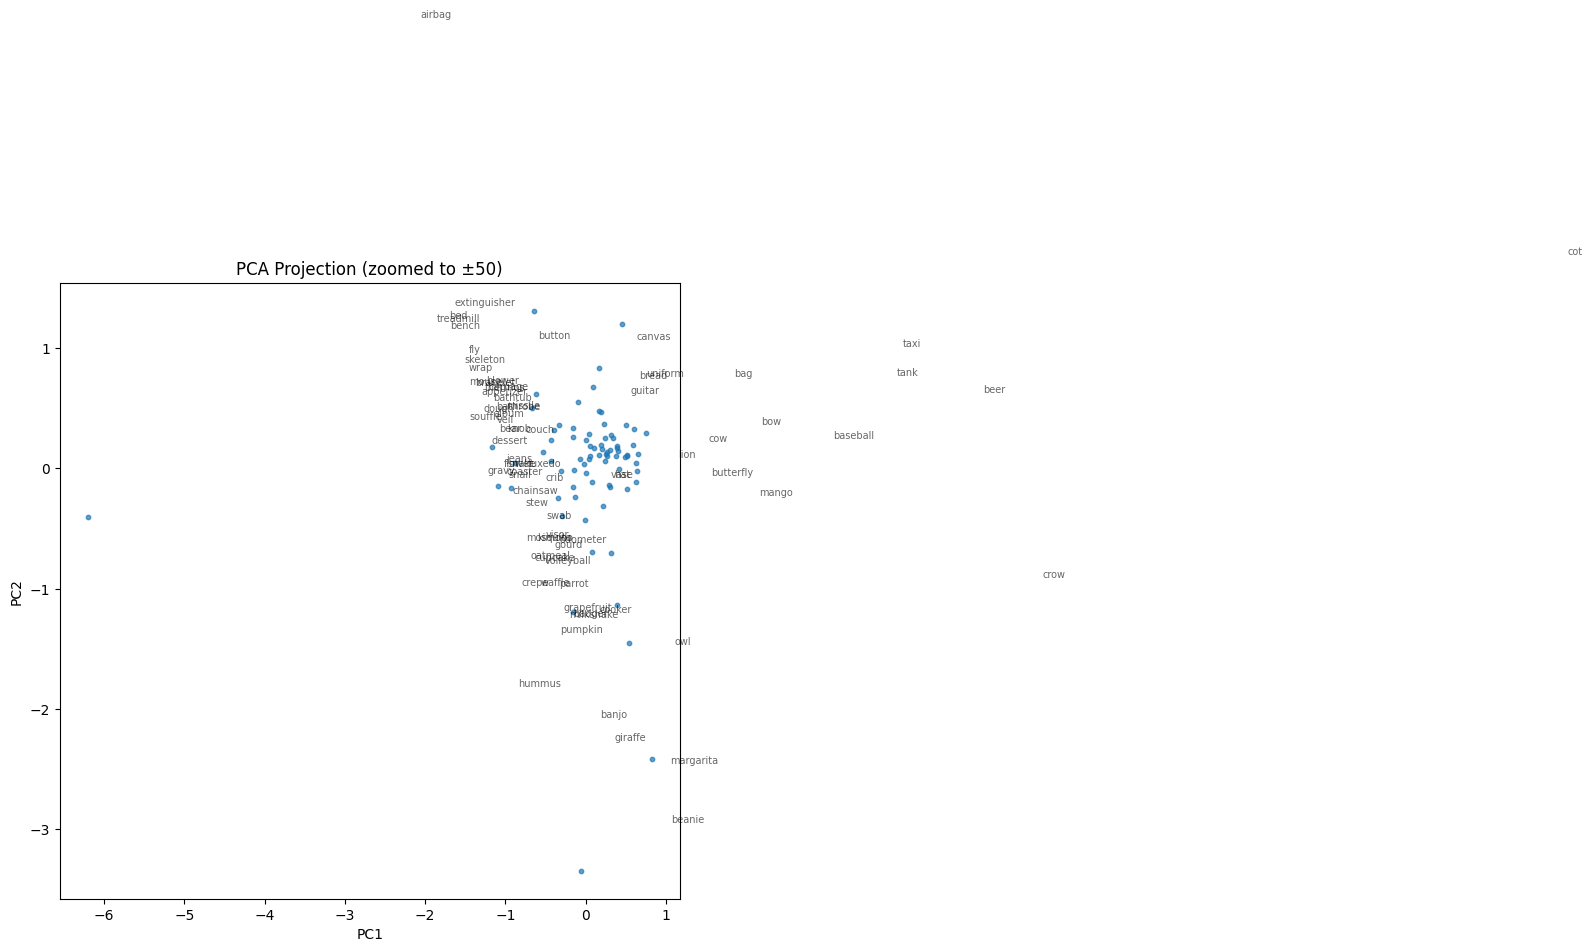

In [38]:
import matplotlib.pyplot as plt

df = embed_20.copy()
if "Unnamed: 0" in df.columns:
    labels = df["Unnamed: 0"]
    df = df.drop(columns=["Unnamed: 0"])
else:
    labels = df.index

# ensure numeric column names
df.columns = [str(c) for c in df.columns]

plt.figure(figsize=(8, 8))
plt.scatter(df["4"], df["7"], s=10, alpha=0.7)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection (zoomed to ±50)")

for i, label in enumerate(labels):
    plt.text(df.iloc[i, 0], df.iloc[i, 1], label, fontsize=7, alpha=0.6)

plt.show()
